In [18]:
import numpy as np
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,explained_variance_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import load_boston
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [19]:
scaler = StandardScaler()
forest = RandomForestRegressor(n_estimators=100,n_jobs=-1)
linreg = LinearRegression(normalize=True)
boosting = LGBMRegressor()
pca = PCA(3)

## Цель вычислительного эксперимента:
Необходимо решить задачу регрессии с использованием моделей: линейная регрессия, линейная регрессия + метод главных компонент, простая нейросеть и критериями качества: квадратичная ошибка, число обусловленности.
## Описание выборок:
Используется датасет ECoG (electrocorticographic data), уже разбитый на выборки обучение/контроль.
## Блок загрузки и предобработки выборок:

In [20]:
X_train = loadmat('ECoG_X_train.mat')['X_train']
y_train = loadmat('ECoG_Y_train.mat')['Y_train']
X_test = loadmat('ECoG_X_test.mat')['X_hold_out']
y_test = loadmat('ECoG_Y_test.mat')['Y_hold_out']

In [21]:
X_train.shape

(12801, 32, 27)

In [22]:
y_train.shape

(12801, 3)

In [23]:
X_test.shape

(6087, 32, 27)

In [24]:
y_test.shape

(6087, 3)

Объектами X_train, X_test являются матрицы 32x27. Преобразуем их в одномерные векторы:

In [25]:
X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

## Анализ пропусков

In [26]:
np.isnan(X_train).any()

False

In [27]:
np.isnan(y_train).any()

False

Данная выборка не имеет пропусков.

## Список моделей
Для решения поставленной задачи используются следующие модели:
* линейная регрессия
* PCA + линейная регрессия
* простая нейросеть 

## Список критериев качетсва:
* mean squared error
* variance score

## Структурные параметры нейронной сети:
* число и состав признаков
* размерность скрытого пространства
* структура сети

## Способ разбиения выборки на обучение-контроль:
Данные уже разбиты на 2 выборки.

## Линейная регрессия:

In [28]:
model = linreg
pipe = Pipeline(steps=[('model', model)])

In [29]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [30]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

1786.7787691924393 0.0703714702511374


## Линейная регрессия c PCA до 80 компонент

In [31]:
model = linreg
pca = PCA(n_components=80)
pipe = Pipeline(steps=[('pca',pca),('model', model)])

In [32]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [33]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

1634.9602130184223 0.1467494360544288


## Нейронная сеть

In [34]:
def big_model():
    model = Sequential()
    model.add(Dense(512, input_dim=864, kernel_initializer='normal', 
                    activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(256, kernel_initializer='normal', activation='relu',
                   kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [35]:
neural_net = KerasRegressor(big_model,epochs=100, batch_size=200,verbose=1)
model = neural_net
pipe = Pipeline(steps=[('scaler',scaler),('model', model)])

In [36]:
pipe.fit(X_train,y_train)

Epoch 1/100
12801/12801 [==============================] - 2s 178us/step - loss: 13826.9416
Epoch 2/100
12801/12801 [==============================] - 2s 145us/step - loss: 4106.8769
Epoch 3/100
12801/12801 [==============================] - 2s 143us/step - loss: 3307.4679
Epoch 4/100
12801/12801 [==============================] - 2s 145us/step - loss: 3014.8762
Epoch 5/100
12801/12801 [==============================] - 2s 142us/step - loss: 2704.6778
Epoch 6/100
12801/12801 [==============================] - 2s 147us/step - loss: 2511.1328
Epoch 7/100
12801/12801 [==============================] - 2s 146us/step - loss: 2389.2103
Epoch 8/100
12801/12801 [==============================] - 2s 146us/step - loss: 2233.0734
Epoch 9/100
12801/12801 [==============================] - 2s 149us/step - loss: 2113.7736
Epoch 10/100
12801/12801 [==============================] - 2s 158us/step - loss: 2028.6532
Epoch 11/100
12801/12801 [==============================] - 2s 147us/step - loss: 1898.8

12801/12801 [==============================] - 2s 152us/step - loss: 407.8288
Epoch 91/100
12801/12801 [==============================] - 2s 154us/step - loss: 411.6233
Epoch 92/100
12801/12801 [==============================] - 2s 179us/step - loss: 398.3094
Epoch 93/100
12801/12801 [==============================] - 2s 168us/step - loss: 415.3668
Epoch 94/100
12801/12801 [==============================] - 2s 172us/step - loss: 392.7755
Epoch 95/100
12801/12801 [==============================] - 2s 142us/step - loss: 385.8142
Epoch 96/100
12801/12801 [==============================] - 2s 144us/step - loss: 402.8084
Epoch 97/100
12801/12801 [==============================] - 2s 153us/step - loss: 390.5092
Epoch 98/100
12801/12801 [==============================] - 2s 159us/step - loss: 389.1342
Epoch 99/100
12801/12801 [==============================] - 2s 189us/step - loss: 397.8578
Epoch 100/100
12801/12801 [==============================] - 2s 188us/step - loss: 394.2945


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd6ec452fd0>)])

In [37]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

6087/6087 [==============================] - 1s 91us/step
2332.629741946544 -0.17965804136300276


## Графики

##### Зависимость функции ошибки от количества эпох

In [47]:
results = np.zeros((5, 5))
N = 1218
for i, n_epoch in enumerate([1,5,10,20,50]):
    model = KerasRegressor(big_model,epochs=n_epoch, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    for j in range(5):
        results[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)],
                                           res[N * j: N * (j + 1)])

In [48]:
results

array([[4569.91055308, 5012.51786228, 4277.85763436, 4546.70370505,
        4328.95583161],
       [2505.65580119, 2789.00047169, 2285.42403887, 3047.51039107,
        2784.95535496],
       [3187.45148495, 3263.25880654, 3078.71302404, 3242.64821162,
        2757.90914865],
       [2396.02436322, 3292.38280118, 2041.26333932, 2713.75580987,
        2890.06975869],
       [2601.56828163, 3753.07692081, 2202.77204714, 2998.7842833 ,
        3507.00173318]])

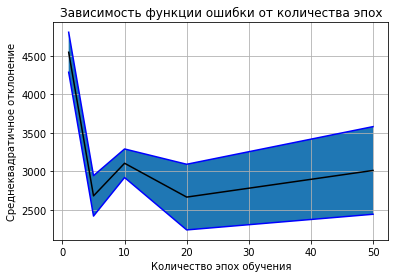

In [50]:
x_ticks = [1,5,10,20,50]
results_mean = np.mean(results, axis=1)
results_std = np.std(results, axis=1)
plt.plot(x_ticks, results_mean, 'k-')
plt.plot(x_ticks, results_mean - results_std, 'b-')
plt.plot(x_ticks, results_mean + results_std, 'b-')
plt.fill_between(x_ticks, results_mean - results_std, results_mean + results_std)
plt.grid()
plt.title('Зависимость функции ошибки от количества эпох')
plt.xlabel("Количество эпох обучения")
plt.ylabel("Среднеквадратичное отклонение")
plt.show()

##### Зависимость функции ошибки от размера скрытого слоя

In [52]:
def variable_model():
    model = Sequential()
    model.add(Dense(64, input_dim=864, kernel_initializer='normal', activation='relu'))
    for i in range(n_l-1):
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model
results1 = np.zeros((3,5))
n_layers = [1,2,3]
for i, n_l in enumerate(n_layers):
    model = KerasRegressor(variable_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    for j in range(5):
        results1[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)], res[N * j: N * (j + 1)])

In [55]:
results1

array([[4459.67106945, 4890.31655815, 3941.06789619, 4523.3945766 ,
        4297.1579745 ],
       [2392.58870991, 2882.90961967, 2121.09892981, 2700.03479441,
        2798.22901469],
       [2541.41769657, 2911.49202871, 2271.01093711, 2984.73926444,
        2667.73825071]])

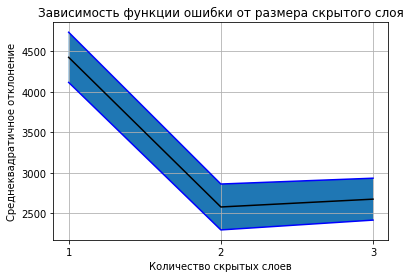

In [54]:
results1_mean = np.mean(results1, axis=1)
results1_std = np.std(results1, axis=1)
fig, ax = plt.subplots()
ax.set_xlabel("Количество скрытых слоев")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(n_layers)
plt.plot(n_layers, results1_mean, 'k-')
plt.plot(n_layers, results1_mean - results1_std, 'b-')
plt.plot(n_layers, results1_mean + results1_std, 'b-')
plt.fill_between(n_layers, results1_mean - results1_std, results1_mean + results1_std)
plt.grid()
plt.show()

##### Зависимость функции ошибки от размера обучающей выборки

In [58]:
percents_of_data = [0.1,0.2,0.3,0.5,0.8,1.0]
results3 = np.zeros((6, 5))
for i, pod in enumerate(percents_of_data):
    model = KerasRegressor(big_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train[:int(len(X_train)*pod)],y_train[:int(len(X_train)*pod)])
    res = pipe.predict(X_test)
    for j in range(5):
        results3[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)], res[N * j: N * (j + 1)])

In [59]:
results3

array([[5446.2258489 , 4709.43085895, 5602.62709673, 5386.65219092,
        4655.4724349 ],
       [3791.06176671, 3598.5409162 , 3744.0984689 , 4104.49428603,
        3550.56700095],
       [3920.09423252, 3558.16307074, 3891.96906894, 3781.08513912,
        3504.17818583],
       [3670.57506937, 3750.95994031, 3456.65627776, 3560.79451291,
        3628.13201099],
       [2103.65891252, 2666.37717049, 1830.25414167, 2544.09178049,
        2648.33948823],
       [2667.3451799 , 2918.71788949, 2444.8128165 , 2768.48396353,
        2550.68465311]])

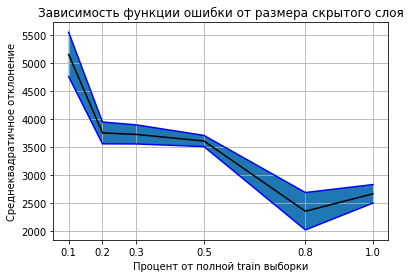

In [60]:
results3_mean = np.mean(results3, axis=1)
results3_std = np.std(results3, axis=1)
fig, ax = plt.subplots()
#ax.set_ylim(0,60)
ax.set_xlabel("Процент от полной train выборки")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(percents_of_data)
plt.plot(percents_of_data, results3_mean, 'k-')
plt.plot(percents_of_data, results3_mean - results3_std, 'b-')
plt.plot(percents_of_data, results3_mean + results3_std, 'b-')
plt.fill_between(percents_of_data, results3_mean - results3_std, results3_mean + results3_std)
plt.grid()
plt.show()

## Анализ результатов

|                    | linreg  | linreg + PCA | neural_net |
|--------------------|---------|--------------|------------|
| mean squared error | 1786.77 | 1634.90      | 2201.43    | 
| variance score     | 0.070   | 0.147        | -0.240     |

## Вывод
Можно сделать вывод, что наилучшие результаты показывает linear regression + 80-component PCA.

# Синтетическая выборка
В качестве синтетической выборки для задачи регрессии возьмём Boston dataset.

In [61]:
dataset = load_boston()

In [62]:
dataset.data.shape

(506, 13)

In [78]:
y = dataset.target
X = dataset.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=228)

## Линейная регрессия

In [64]:
model = linreg
pipe = Pipeline(steps=[('model', model)])

In [65]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [66]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

31.84400099655244 0.7013949934877279


## Линейная регрессия c PCA до 8 компонент

In [67]:
model = linreg
pca = PCA(n_components=8)
pipe = Pipeline(steps=[('pca',pca),('model', model)])

In [68]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [69]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

49.06022977053876 0.5449917208136847


## Нейронная сеть

In [70]:
def small_model():
    model = Sequential()
    model.add(Dense(128, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [71]:
neural_net = KerasRegressor(small_model,epochs=200, batch_size=100,verbose=0)
model = neural_net
pipe = Pipeline(steps=[('scaler',scaler),('model', model)])

In [72]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd6d360ba90>)])

In [73]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

11.015076732376858 0.8960202502977511


## Графики

##### Зависимость функции ошибки от количества эпох

In [81]:
results = np.zeros((8, 5))
N = 26
for i, n_epoch in enumerate([1,5,10,20,50,100,200,500]):
    model = KerasRegressor(small_model,epochs=n_epoch, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    for j in range(5):
        results[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)],
                                           res[N * j: N * (j + 1)])

In [82]:
results

array([[588.55591617, 800.37676391, 541.50012345, 749.66211925,
        570.88272409],
       [508.42827134, 707.10844634, 472.86396325, 656.67109527,
        501.77996136],
       [296.32989856, 470.48872587, 307.76984998, 403.79549346,
        319.74831032],
       [ 74.0696805 , 155.49292005,  83.49085238, 109.01707561,
         75.9354363 ],
       [ 18.35862169,  64.41567193,  17.09276508,  11.94226864,
          7.48491999],
       [ 10.64446066,  31.28309395,  10.34166804,   6.75535306,
          5.13119643],
       [  9.05678462,  20.23943936,   9.93137782,   6.50863175,
          5.56096751],
       [ 10.67959145,  10.31300342,   9.33933722,   6.88691065,
          7.28555315]])

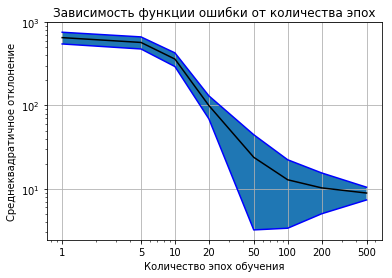

In [83]:
results_mean = np.mean(results, axis=1)
results_std = np.std(results, axis=1)
x_ticks = [1,5,10,20,50,100,200,500]
fig, ax = plt.subplots()
plt.plot(x_ticks, results_mean, 'k-')
plt.plot(x_ticks, results_mean - results_std, 'b-')
plt.plot(x_ticks, results_mean + results_std, 'b-')
plt.fill_between(x_ticks, results_mean - results_std, results_mean + results_std)
plt.grid()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)
ax.set_title('Зависимость функции ошибки от количества эпох')
ax.set_xlabel("Количество эпох обучения")
ax.set_ylabel("Среднеквадратичное отклонение")
plt.show()

##### Зависимость функции ошибки от размера скрытого слоя

In [85]:
def variable_model():
    model = Sequential()
    model.add(Dense(64, input_dim=13, kernel_initializer='normal', activation='relu'))
    for i in range(n_l-1):
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model
results1 = np.zeros((5, 5))
n_layers = [1,2,3,5,10]
for i, n_l in enumerate(n_layers):
    model = KerasRegressor(variable_model,epochs=200, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    for j in range(5):
        results1[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)], res[N * j: N * (j + 1)])

In [88]:
results1

array([[17.59480924, 54.01601583, 12.71965805, 11.19683585,  6.58949272],
       [11.86632501, 22.77298046, 10.72590175,  7.41086292,  5.56763962],
       [10.70956175, 24.50284219,  9.90847772,  7.76224494,  5.09098941],
       [ 9.26822945, 17.22824635, 12.05889931,  9.02318618,  9.70527924],
       [ 8.88800241, 22.4141463 , 13.29210806, 12.69009511, 14.59686595]])

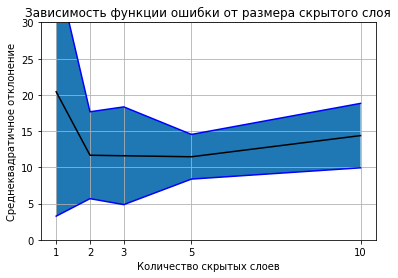

In [87]:
results1_mean = np.mean(results1, axis=1)
results1_std = np.std(results1, axis=1)
fig, ax = plt.subplots()
ax.set_ylim(0,30)
ax.set_xlabel("Количество скрытых слоев")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(n_layers)
plt.plot(n_layers, results1_mean, 'k-')
plt.plot(n_layers, results1_mean - results1_std, 'b-')
plt.plot(n_layers, results1_mean + results1_std, 'b-')
plt.fill_between(n_layers, results1_mean - results1_std, results1_mean + results1_std)
plt.grid()
plt.show()

##### Зависимость функции ошибки от размера обучающей выборки

In [89]:
percents_of_data = [0.1,0.2,0.3,0.5,0.8,1.0]
results3 = np.zeros((6, 5))
for i, pod in enumerate(percents_of_data):
    model = KerasRegressor(small_model,epochs=100, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train[:int(len(X_train)*pod)],y_train[:int(len(X_train)*pod)])
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    for j in range(5):
        results3[i][j] = mean_squared_error(y_test[N * j: N * (j + 1)], res[N * j: N * (j + 1)])

In [90]:
results3

array([[ 39.26496364, 125.25234136,  28.80575555,  32.3160941 ,
         31.61399156],
       [ 45.71867795,  82.57181656,  29.47177725,  27.00505718,
         30.71210084],
       [ 23.73976423,  51.12091818,  16.76351469,  10.64888061,
         12.67334685],
       [ 15.25653084,  51.57973858,  12.16857357,  10.7065328 ,
          6.5929573 ],
       [  9.90118696,  53.84111241,  11.18194535,   9.95077099,
          4.9313148 ],
       [ 10.90012465,  32.23885325,   9.8241123 ,   7.94993799,
          4.87686346]])

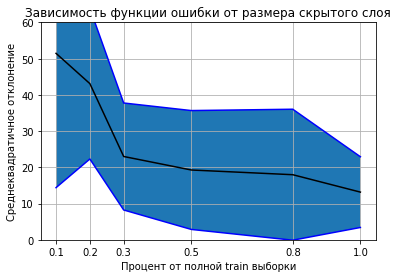

In [91]:
results3_mean = np.mean(results3, axis=1)
results3_std = np.std(results3, axis=1)
fig, ax = plt.subplots()
ax.set_ylim(0,60)
ax.set_xlabel("Процент от полной train выборки")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(percents_of_data)
plt.plot(percents_of_data, results3_mean, 'k-')
plt.plot(percents_of_data, results3_mean - results3_std, 'b-')
plt.plot(percents_of_data, results3_mean + results3_std, 'b-')
plt.fill_between(percents_of_data, results3_mean - results3_std, results3_mean + results3_std)
plt.grid()
plt.show()